In [1]:
import numpy as np
import pandas as pd
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization, Add, GlobalAveragePooling2D, SpatialDropout2D, ReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import joblib

np.random.seed(3)

In [2]:
# @title Load data
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df.shape

(42000, 785)

# Normalize the data

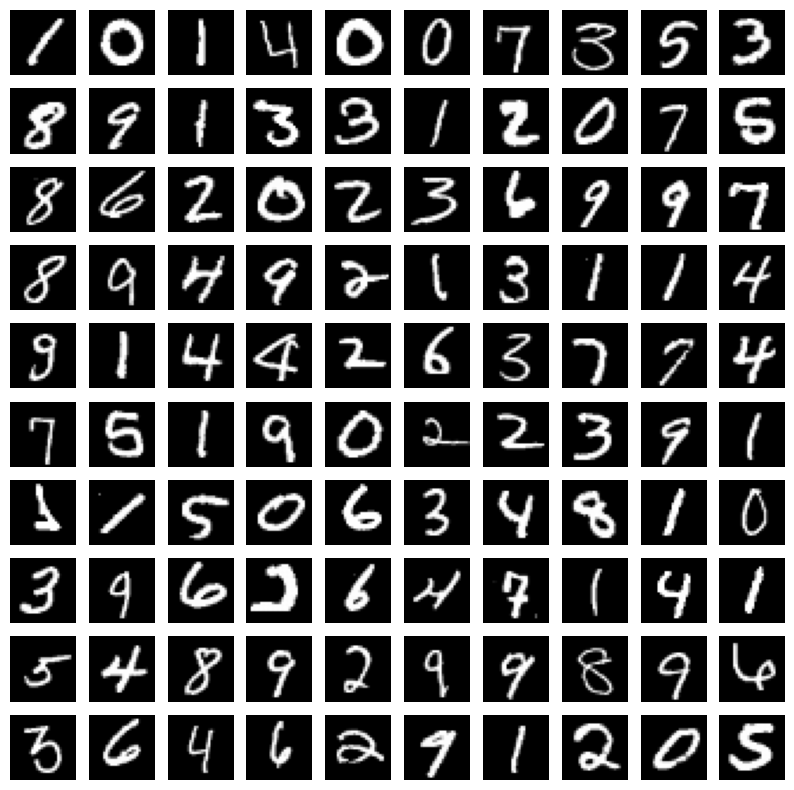

In [5]:
# @title Images before preprocessing
num_images=100
grid_size = int(np.sqrt(num_images))

# Set up the grid
plt.figure(figsize=(10, 10))

for i in range(num_images):
    # Get the image data from the dataframe
    temp_image = train_df.iloc[i, 1:].values
    temp_image = temp_image.reshape(28, 28)

    # Create a subplot for each image
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(temp_image, cmap='gray')
    plt.axis('off')  # Hide axis for a cleaner look

plt.show()

In [6]:
def preprocessing(image):
    # Convert to NumPy array and reshape it to a 2D image (28x28) if needed
    img = np.array(image).reshape(28, 28).astype(np.uint8)
    
    # Apply Otsu's thresholding
    _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU +cv2.THRESH_BINARY)
    coords = cv2.findNonZero(binary_img)

    x, y, w, h = cv2.boundingRect(coords)
    # Crop and center
    cropped_img = binary_img[y:y+h, x:x+w]
    # Calculate padding
    pad_x = (28 - w) // 2
    pad_y = (28 - h) // 2

    # Add padding to center the digit
    padded_img = cv2.copyMakeBorder(cropped_img, pad_y, 28 - h - pad_y, pad_x, 28 - w - pad_x, cv2.BORDER_CONSTANT, value=0)

    return padded_img.flatten()//255

In [7]:
train_df[train_df.columns[1:]] = train_df[train_df.columns[1:]].apply(lambda row: preprocessing(row), axis=1, result_type='expand')
test_df=test_df.apply(lambda row: preprocessing(row), axis=1, result_type='expand')

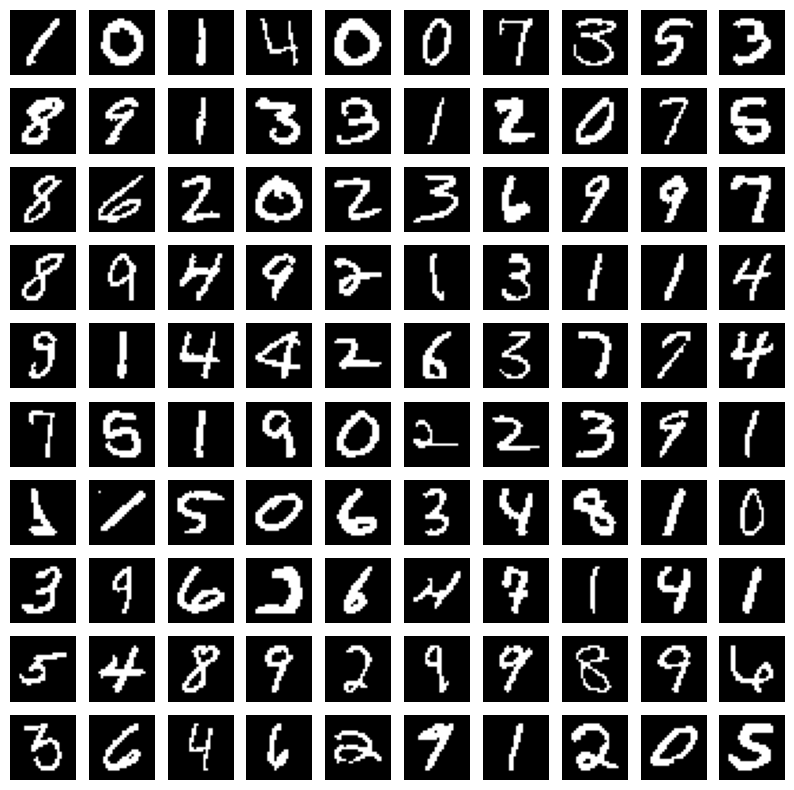

In [8]:
# @title Images after preprocessing
num_images=100
grid_size = int(np.sqrt(num_images))

# Set up the grid
plt.figure(figsize=(10, 10))

for i in range(num_images):
    # Get the image data from the dataframe
    temp_image = train_df.iloc[i, 1:].values
    temp_image = temp_image.reshape(28, 28)

    # Create a subplot for each image
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(temp_image, cmap='gray')
    plt.axis('off')  # Hide axis for a cleaner look

plt.show()

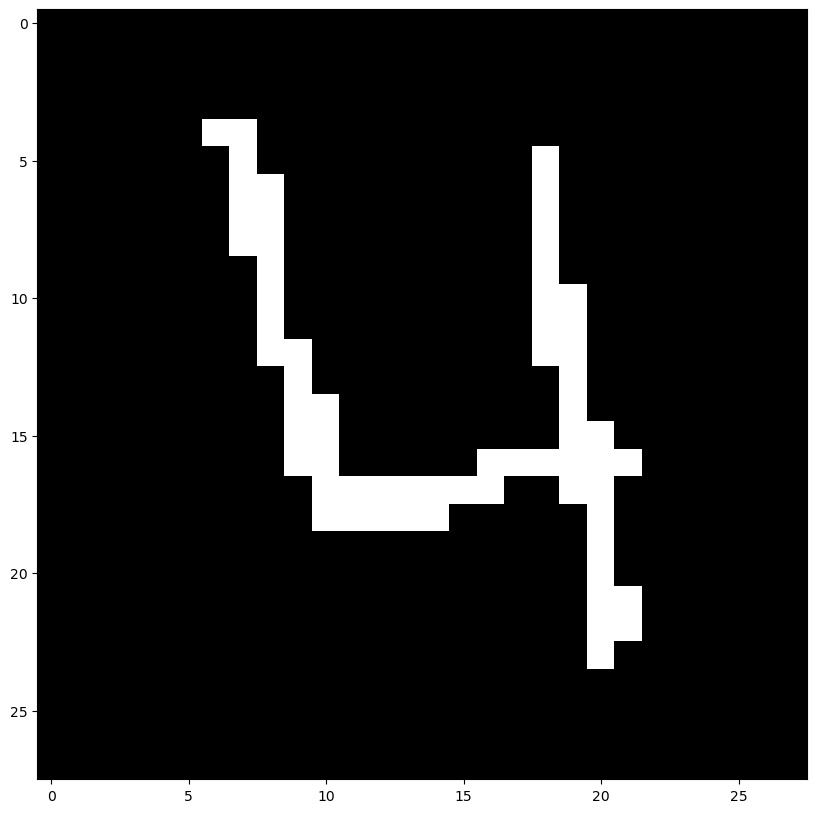

In [9]:
# @title Visualize a sample image
temp_image = train_df.iloc[3, 1:].values
temp_image=temp_image.reshape(28, 28)
plt.figure(figsize=(10,10))
plt.imshow(temp_image, cmap='gray')
plt.show()

# Training

## Create Model

In [10]:
def residual_block(fx, filters,kernel_size=(3,3),padding='same'):
    # First convolution
    x = Conv2D(filters=filters, kernel_size=kernel_size,padding='same')(fx)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    # Second convolution
    x = Conv2D(filters=filters, kernel_size=kernel_size,padding='same')(x)
    x = BatchNormalization()(x)
    # Shortcut
    if x.shape[-1] != fx.shape[-1]:
        fx = Conv2D(filters, kernel_size=(1, 1), padding='same')(fx)
    out = Add()([x, fx])
    out = ReLU()(out)
    return out

In [11]:
inputs = Input(shape=(28, 28, 1))

# İnitial convolutional block
x = Conv2D(filters=32, kernel_size=(3,3))(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(filters=32, kernel_size=(3,3))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

# First branch
x0 = Conv2D(filters=64, kernel_size=(3,3))(x)
x0 = BatchNormalization()(x0)
x0 = ReLU()(x0)
x0 = Conv2D(filters=64, kernel_size=(3,3))(x0)
x0 = BatchNormalization()(x0)
x0 = ReLU()(x0)
x0 = Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same')(x0)
x0 = BatchNormalization()(x0)
x0 = ReLU()(x0)
x0 = Dropout(0.4)(x0)


# Second brach with residual block
x1 = residual_block(x, 64,(3,3))
x1 = Conv2D(filters=64, kernel_size=(5,5), strides=(2,2))(x1)
x1 = BatchNormalization()(x1)
x1 = ReLU()(x1)
x1 = Dropout(0.4)(x1)


# Combine both branches
x = Add()([x0,x1])
x = ReLU()(x)

# Fully connected layers
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 26, 26, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 26, 26, 32)   0           ['batch_normalization[0][0]']

## Training

### Preprocess the Data

In [14]:
X = train_df.drop('label', axis=1)
X = X.to_numpy()

y = train_df['label']

# Reshape data
X = X.reshape(-1, 28, 28, 1)
# One-hot encode the labels
y = to_categorical(y, num_classes=10)

del train_df

In [15]:
# @title Split the data into training set and validation set
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X, y, test_size=0.2, random_state=42)

### Data Augmentation

In [16]:
datagen = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
)

### Training

In [ ]:
loss_fn = CategoricalCrossentropy()
model.compile(optimizer=Adam(), loss=loss_fn, metrics=['accuracy'])
# Define the learning rate scheduler and model checkpoint callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6,restore_best_weights=True)

In [ ]:
history = model.fit(datagen.flow(X_train_split, y_train_split, batch_size=128),
                    epochs=50, validation_data=(X_val_split, y_val_split),
                    callbacks=[lr_scheduler], verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


263/263 ━━━━━━━━━━━━━━━━━━━━ 204s 740ms/step - accuracy: 0.5567 - loss: 1.3806 - val_accuracy: 0.9135 - val_loss: 0.3135 - learning_rate: 0.0010
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 192s 728ms/step - accuracy: 0.9374 - loss: 0.2149 - val_accuracy: 0.9744 - val_loss: 0.0838 - learning_rate: 0.0010
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 193s 733ms/step - accuracy: 0.9576 - loss: 0.1447 - val_accuracy: 0.9555 - val_loss: 0.1570 - learning_rate: 0.0010
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 192s 731ms/step - accuracy: 0.9663 - loss: 0.1167 - val_accuracy: 0.9729 - val_loss: 0.0847 - learning_rate: 0.0010
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 192s 730ms/step - accuracy: 0.9730 - loss: 0.0914 - val_accuracy: 0.9895 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 192s 728ms/step - accuracy: 0.9744 - loss: 0.0856 - val_accuracy: 0.9886 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 191s 727ms/step - accuracy: 0.9792 

# Submission

In [ ]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_sub = test_df.to_numpy()

X_sub = X_sub.reshape(-1, 28, 28, 1)

### Predictions

In [ ]:
predictions = model.predict(X_sub)

875/875 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step


In [ ]:
class_predictions = np.argmax(predictions, axis=1)

In [ ]:
class_predictions

array([2, 0, 9, ..., 3, 9, 2])

### Save submissions

In [ ]:
submission_df=pd.read_csv('sample_submission.csv')

In [ ]:
submission_final = pd.DataFrame({
    'ImageId': submission_df['ImageId'],
    'label': class_predictions
})
submission_final.head()

,ImageId,label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [ ]:
submission_final.to_csv('submission_final.csv', index=False)

### Save model

In [ ]:
joblib.dump(model, 'model.pkl')

['model.pkl']